In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, "/SSF")
from DejaVu.explib.read_model import read_model

Using backend: pytorch


In [2]:
from pathlib import Path
exp_dir = Path('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451')

from DejaVu.models import get_GAT_model
model, y_probs, y_preds = read_model(
    exp_dir,
    get_GAT_model,
    override_config=dict(data_dir=Path("/SSF/data/A1"), flush_dataset_cache=False)
)

cdp = fdg = model.fdg
config = model.config
cache = model.cache

output_dir = config.output_dir / 'LIME_explain'
output_dir.mkdir(exist_ok=True, parents=True)
print(output_dir)

2022-03-18 09:48:32.055 | DEBUG    | utils.load_model:best_checkpoint:19 - path=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451') metric='val_loss' mode='min'
2022-03-18 09:48:32.100 | DEBUG    | utils.load_model:best_checkpoint:40 - ckpt_path=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lightning_logs/version_0/checkpoints/epoch=449-A@1=0.647059-val_loss=0.296444-MAR=2.235294.ckpt') has metrics: {'epoch': '449', 'A@1': '0.647059', 'val_loss': '0.296444', 'MAR': '2.235294'}
2022-03-18 09:48:32.101 | DEBUG    | utils.load_model:best_checkpoint:40 - ckpt_path=PosixPath('/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/lightning_logs/version_0/checkpoints/epoch=119-A@1=0.882353-val_loss=0.346040-MAR=1.470588.ckpt') has metrics: {'epoch': '119', 'A@1': '0.882353', 'val_loss': '0.346040', 'MAR': '1.470588'}
2022-03-18 09:48:32.101 | DEBUG    | utils.lo

/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:50:07.949451/LIME_explain


In [3]:
from DejaVu.models import DejaVuModelInterface
from typing import Callable
from einops import rearrange, repeat
import torch as th
import numpy as np
def wrap_predictor_for_DejaVu_model(model: DejaVuModelInterface, failure_instance: str, failure_id: int, metric_local_id=None) -> Callable:
    if failure_id in model.train_failure_ids:
        dataset = model.train_dataset
    elif failure_id in model.validation_failure_ids:
        dataset = model.validation_dataset
    else:
        dataset = model.test_dataset
    features, _, _, g = dataset[dataset.fault_ids.tolist().index(failure_id)]
    global_id = model.fdg.instance_to_gid(failure_instance)
    failure_class, local_id = model.fdg.instance_to_local_id(failure_instance)
    failure_class_id = model.fdg.failure_classes.index(failure_class)
    
    def func(ts: np.ndarray):
        device = model.device
        model.to(device)
        new_features = []
        for fc_id in range(len(model.fdg.failure_classes)):
            feat = repeat(features[fc_id], "i m t -> b i m t", b=ts.shape[0]).to(device=device, dtype=th.float32)
            if fc_id == failure_class_id:
                if metric_local_id is None:
                    feat[:, local_id, :, :] = th.from_numpy(ts).to(device=device, dtype=th.float32)
                else:
                    feat[:, local_id, metric_local_id, :] = th.from_numpy(ts).to(device=device, dtype=th.float32)
            # print(feat.shape)
            new_features.append(feat)
        probs = th.sigmoid(model(new_features, [g]).detach()).numpy()[:, global_id]
        return np.vstack([1-probs, probs]).T
    return func

In [4]:
from DejaVu.explanability.lime_timeseries import LimeTimeSeriesExplainer
import pandas as pd
def get_explain(failure_id: int):
    rc_instance = model.fdg.root_cause_instances_of(failure_id)[0]
    rc_class = model.fdg.instance_to_class(rc_instance)
    _, local_id = model.fdg.instance_to_local_id(rc_instance)
    rc_class_id = model.fdg.failure_classes.index(rc_class)
    print(f"{failure_id=} {rc_instance=}")
    explainer = LimeTimeSeriesExplainer(class_names=['non-root-cause', 'root-cause'], signal_names=model.fdg.FC_metrics_dict[rc_class])
    num_features = 500  # how many feature contained in explanation
    num_slices = 1  # split time series
    if failure_id in model.train_failure_ids:
        dataset = model.train_dataset
    elif failure_id in model.validation_failure_ids:
        dataset = model.validation_dataset
    else:
        dataset = model.test_dataset
    ts = dataset[dataset.fault_ids.tolist().index(failure_id)][0][rc_class_id][local_id].numpy()
    exp = explainer.explain_instance(
        ts, wrap_predictor_for_DejaVu_model(model, rc_instance, failure_id), 
        num_features=num_features, num_samples=1000, num_slices=num_slices, 
        replacement_method='total_mean'
    )
    df = pd.DataFrame(exp.as_list(), columns=["feature", "importance"])
    df['feature'] = df['feature'].map(lambda _: _.split(" - ")[1])
    df = df.groupby(['feature']).sum().reset_index()
    df = df.sort_values(by="importance", ascending=False)
    return df

get_explain(73)

/opt/conda/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


failure_id=73 rc_instance='os_017 Network'


,feature,importance
5,Recv_total,0.001181
4,Received_queue,0.001158
10,ss_total,0.001132
9,Sent_queue,0.001090
7,Sent_errors_packets,0.001037
3,Received_packets,0.001019
6,Send_total,0.000931
1,Outgoing_network_traffic,0.000843
8,Sent_packets,0.000841
2,Received_errors_packets,0.000732


In [7]:
get_explain(14)

failure_id=14 rc_instance='os_018 Network'


,feature,importance
0,Incoming_network_traffic,0.001006
2,Received_errors_packets,0.000982
1,Outgoing_network_traffic,0.000943
4,Received_queue,0.000889
3,Received_packets,0.000868
10,ss_total,0.000863
7,Sent_errors_packets,0.000839
8,Sent_packets,0.000741
6,Send_total,0.000709
5,Recv_total,0.000673


In [8]:
get_explain(20)

failure_id=20 rc_instance='os_021 Network'


,feature,importance
5,Recv_total,0.001123
10,ss_total,0.001072
4,Received_queue,0.001033
2,Received_errors_packets,0.000888
1,Outgoing_network_traffic,0.000864
8,Sent_packets,0.000824
7,Sent_errors_packets,0.000758
3,Received_packets,0.000698
0,Incoming_network_traffic,0.000697
9,Sent_queue,0.000695


In [5]:
from tqdm import tqdm
exp_df_list = []
for fid in tqdm([_ for _ in model.fdg.failure_ids if model.fdg.instance_to_class(model.fdg.root_cause_instances_of(_)[0]) == "OS Network"]):
    __df = get_explain(fid)
    __df["fid"] = fid
    exp_df_list.append(__df)
exp_df = pd.concat(exp_df_list)
exp_df

  0%|          | 0/17 [00:00<?, ?it/s]

failure_id=14 rc_instance='os_018 Network'


  6%|▌         | 1/17 [00:00<00:15,  1.04it/s]

failure_id=20 rc_instance='os_021 Network'


 12%|█▏        | 2/17 [00:01<00:14,  1.02it/s]

failure_id=22 rc_instance='os_021 Network'


 18%|█▊        | 3/17 [00:02<00:13,  1.01it/s]

failure_id=32 rc_instance='os_020 Network'


 24%|██▎       | 4/17 [00:03<00:12,  1.01it/s]

failure_id=33 rc_instance='os_017 Network'


 29%|██▉       | 5/17 [00:04<00:11,  1.01it/s]

failure_id=38 rc_instance='os_021 Network'


 35%|███▌      | 6/17 [00:05<00:10,  1.01it/s]

failure_id=39 rc_instance='os_018 Network'


 41%|████      | 7/17 [00:06<00:09,  1.01it/s]

failure_id=40 rc_instance='os_020 Network'


 47%|████▋     | 8/17 [00:07<00:08,  1.00it/s]

failure_id=42 rc_instance='os_018 Network'


 53%|█████▎    | 9/17 [00:08<00:07,  1.00it/s]

failure_id=43 rc_instance='os_017 Network'


 59%|█████▉    | 10/17 [00:09<00:07,  1.02s/it]

failure_id=51 rc_instance='os_021 Network'


 65%|██████▍   | 11/17 [00:11<00:06,  1.04s/it]

failure_id=55 rc_instance='os_018 Network'


 71%|███████   | 12/17 [00:12<00:05,  1.03s/it]

failure_id=61 rc_instance='os_021 Network'


 76%|███████▋  | 13/17 [00:13<00:04,  1.02s/it]

failure_id=64 rc_instance='os_020 Network'


 82%|████████▏ | 14/17 [00:14<00:03,  1.02s/it]

failure_id=66 rc_instance='os_018 Network'


 88%|████████▊ | 15/17 [00:15<00:02,  1.02s/it]

failure_id=72 rc_instance='os_021 Network'


 94%|█████████▍| 16/17 [00:16<00:01,  1.01s/it]

failure_id=73 rc_instance='os_017 Network'


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


,feature,importance,fid
10,ss_total,0.001006,14
1,Outgoing_network_traffic,0.000995,14
4,Received_queue,0.000931,14
3,Received_packets,0.000882,14
2,Received_errors_packets,0.000875,14
...,...,...,...
8,Sent_packets,0.000861,73
0,Incoming_network_traffic,0.000765,73
2,Received_errors_packets,0.000687,73
10,ss_total,0.000628,73


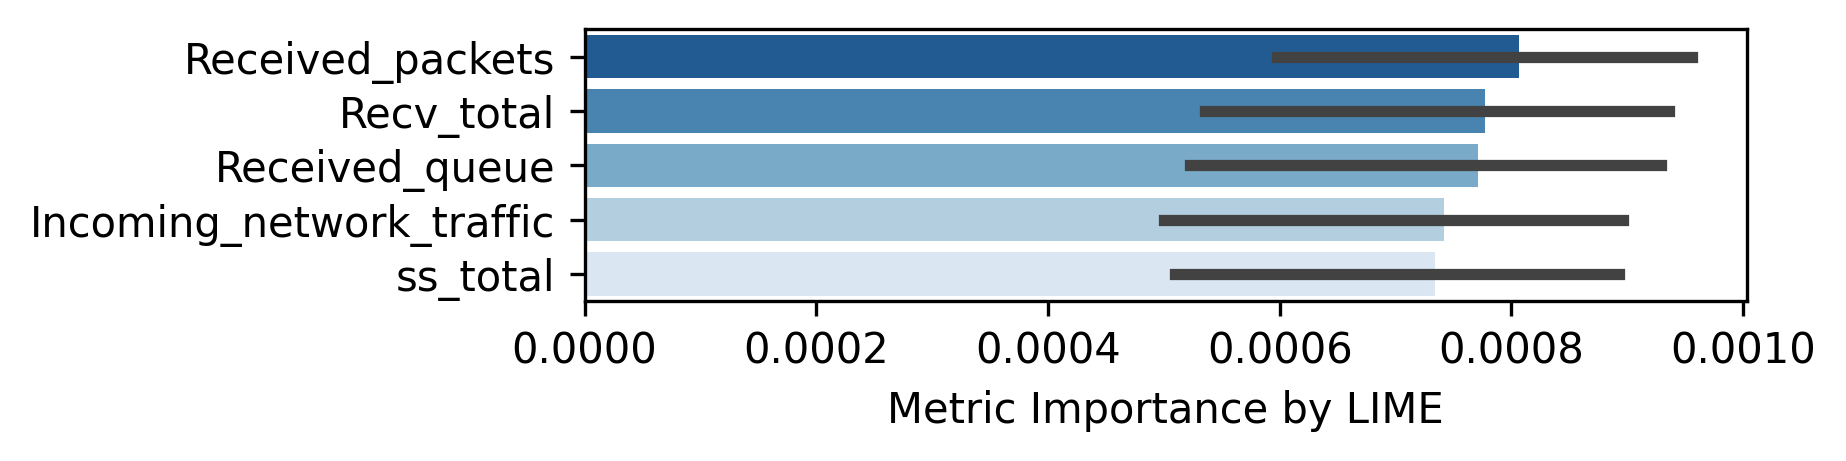

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(dpi=300, figsize=(5, 1.2))
order = exp_df.groupby(["feature"])["importance"].mean().sort_values(ascending=False).index.tolist()[:5]
sns.barplot(data=exp_df[exp_df.feature.isin(order)], y="feature", x="importance", order=order, palette="Blues_r")
plt.ylabel(None)
plt.xlabel("Metric Importance by LIME")
plt.savefig(output_dir / "OS_Network.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

failure_id=14 rc_instance='os_018 Network'
failure_id=20 rc_instance='os_021 Network'


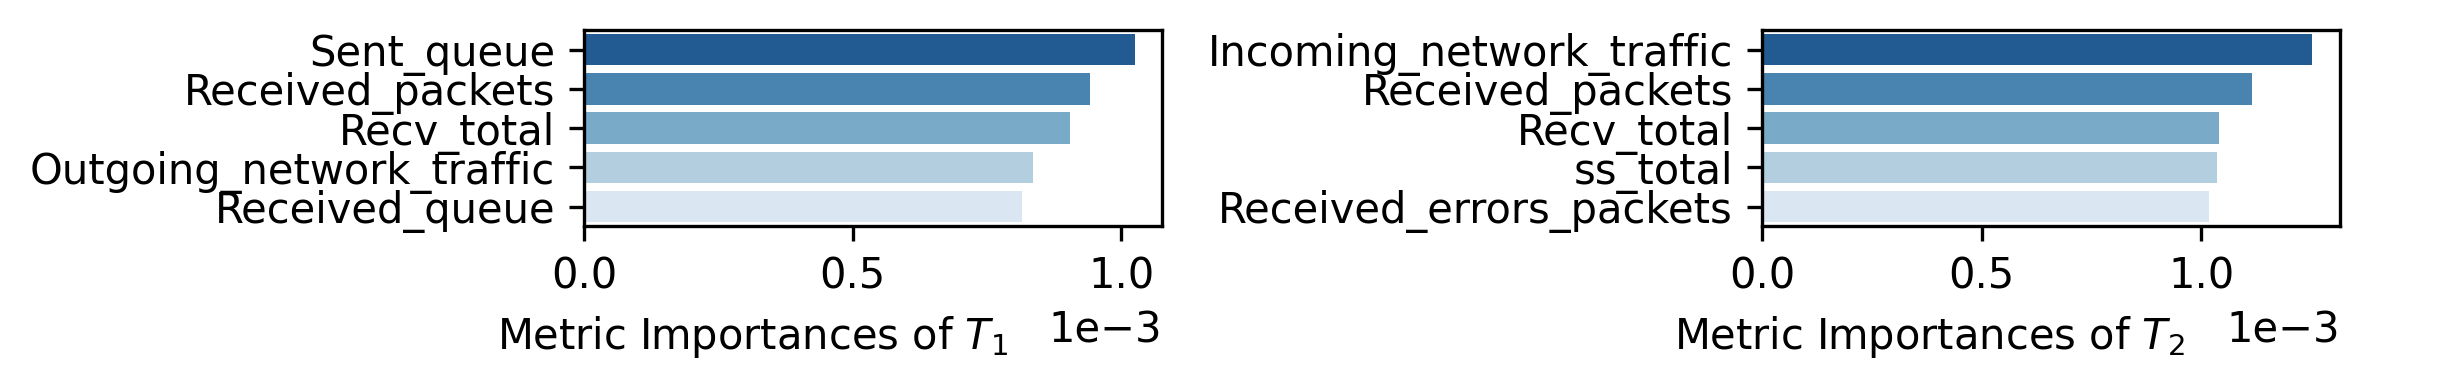

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(8, 1.4))
sns.barplot(data=get_explain(14).iloc[:5], y="feature", x="importance", palette="Blues_r", ax=axes[0])
axes[0].set_ylabel(None)
axes[0].set_xlabel("Metric Importances of $T_1$                   ")
# axes[0].yaxis.set_tick_params(labelsize=9)
# axes[0].xlabel(-0.0007, 5.5, "Feature Importance")
axes[0].ticklabel_format(style="sci", axis="x", scilimits=(-1, 1))

sns.barplot(data=get_explain(20).iloc[:5], y="feature", x="importance", palette="Blues_r", ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_xlabel("Metric Importances of $T_2$                   ")
axes[1].ticklabel_format(style="sci", axis="x", scilimits=(-1, 1))
# axes[0].text(-0.0008, 5.5, "Feature Importance by LIME")
# axes[0].set_xlabel("$T_1$")
# plt.ylabel(None)
# plt.xlabel("Feature Importance by LIME")
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig("/SSF/output/lime_local_interpretation_example.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()